In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
from scipy.special import inv_boxcox
from statsmodels.api import qqplot
import seaborn as sns
from statsmodels.api import OLS
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from scipy.stats import skewnorm, norm, gamma
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import itertools

pd.options.display.float_format = '{:.2f}'.format

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv("forestfires.csv")
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.20,26.20,94.30,5.10,8.20,51,6.70,0.00,0.00
1,7,4,oct,tue,90.60,35.40,669.10,6.70,18.00,33,0.90,0.00,0.00
2,7,4,oct,sat,90.60,43.70,686.90,6.70,14.60,33,1.30,0.00,0.00
3,8,6,mar,fri,91.70,33.30,77.50,9.00,8.30,97,4.00,0.20,0.00
4,8,6,mar,sun,89.30,51.30,102.20,9.60,11.40,99,1.80,0.00,0.00


#Пункт 1 - 2

In [3]:
a = [i for i in range(10)]
b = [i for i in range(10)]
z = list(itertools.product(a,b))

d = {}

for i in z:
  d[i] = 0

for i in z:
  for j in zip(df.X, df.Y):
    if i == j:
      d[i]+=1

df['Z'] = 0

for i in range(len(df)):
  df["Z"][i]=d[(df.X[i], df.Y[i])]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


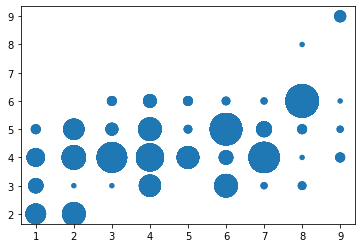

In [4]:
#Визуализирую на вообразимой карте количество данных по пожарам в определенных территориях

x = df.X
y = df.Y
z = df.Z

plt.scatter(x, y, z*20)
plt.show()

In [5]:
# удаляем нулевые значения целевой переменной
df = df[df.area!=0]
df.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,Z
count,270.00,270.00,270.00,270.00,270.00,270.00,270.00,270.00,270.00,270.00,270.00,270.00
mean,4.81,4.37,91.03,114.71,570.87,9.18,19.31,43.73,4.11,0.03,24.60,30.20
std,2.38,1.17,3.71,61.79,229.98,4.15,6.18,15.08,1.88,0.40,86.50,16.03
min,1.00,2.00,63.50,3.20,15.30,0.80,2.20,15.00,0.40,0.00,0.09,1.00
25%,3.00,4.00,90.32,82.90,486.50,6.80,16.12,33.00,2.70,0.00,2.14,20.00
50%,5.00,4.00,91.70,111.70,665.60,8.40,20.10,41.00,4.00,0.00,6.37,27.00
75%,7.00,5.00,92.97,141.30,721.32,11.38,23.40,53.00,4.90,0.00,15.42,45.00
max,9.00,9.00,96.20,291.30,860.60,22.70,33.30,96.00,9.40,6.40,1090.84,52.00


Посмотрим на распределение данных по целевой переменной

Text(0.5, 0, 'Area')

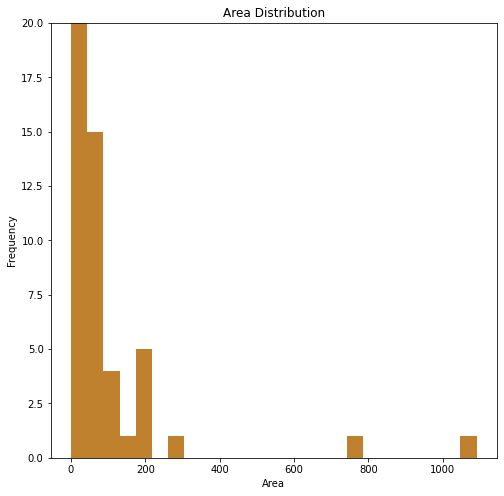

In [6]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot()

n, bins, patches = ax.hist(df['area'], bins = 25, stacked = True, density = False, color = "#bf812d")
ax.set_ylim(0, 20)
ax.set_title("Area Distribution")
ax.set_ylabel("Frequency")
ax.set_xlabel("Area")

Мы видим распределение с большим количеством малых значених целевой переменной, и относительно длинным правым хвостом. Для начала предобработаем данные

Визуально, распределение не похоже на нормальное, давайте проведем более точный визуальный тест (Критерий Шапиро-Уилка не подходит из-за большого количества данных)

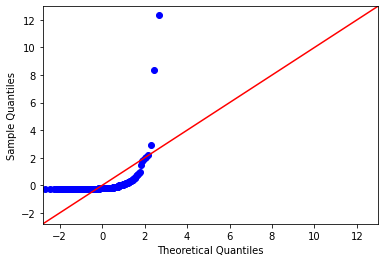

In [7]:
fig = qqplot(df.area, norm, line='45', fit=True)

Распределение далеко не станадартное нормальное, может быть смещенное нормальное?

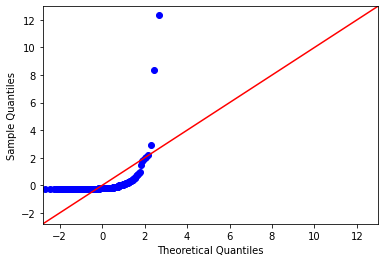

In [8]:
fig = qqplot((df.area - np.mean(df.area)) / np.sqrt(np.var(df.area)),norm, line='45')

Распределение не нормальное, позже будем либо его делать нормальным, либо применть не статистические, а параметрические тесты

In [9]:
for i in df.month.unique():
  print(i, len(df[df.month == i]))

jul 18
sep 97
aug 99
mar 19
jun 8
apr 4
oct 5
feb 10
dec 9
may 1


Исходя из общей логики (погода не живет по календарю, она не знает сегодня вторник или четверг + жесткая мультиколлинеарность исходя из логики, если вдруг такая есть, что месяц определяет погодные условия) и несбалансированности данных, показатели месяца и дня недели были удалены

Данные по местоположению также были удалены, потому что то, как прогревается, продувается и промокает тот или иной участок и определяет этот участок, опять возникает мультиколлинеарность. Эффект того, что дуб может гореть хуже березы на данном этапе изучения проблемы будем считать незначительным.

In [10]:
df = df.drop(columns = ['X','Y','Z', "month", "day"])
df.describe()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,270.00,270.00,270.00,270.00,270.00,270.00,270.00,270.00,270.00
mean,91.03,114.71,570.87,9.18,19.31,43.73,4.11,0.03,24.60
std,3.71,61.79,229.98,4.15,6.18,15.08,1.88,0.40,86.50
min,63.50,3.20,15.30,0.80,2.20,15.00,0.40,0.00,0.09
25%,90.32,82.90,486.50,6.80,16.12,33.00,2.70,0.00,2.14
50%,91.70,111.70,665.60,8.40,20.10,41.00,4.00,0.00,6.37
75%,92.97,141.30,721.32,11.38,23.40,53.00,4.90,0.00,15.42
max,96.20,291.30,860.60,22.70,33.30,96.00,9.40,6.40,1090.84


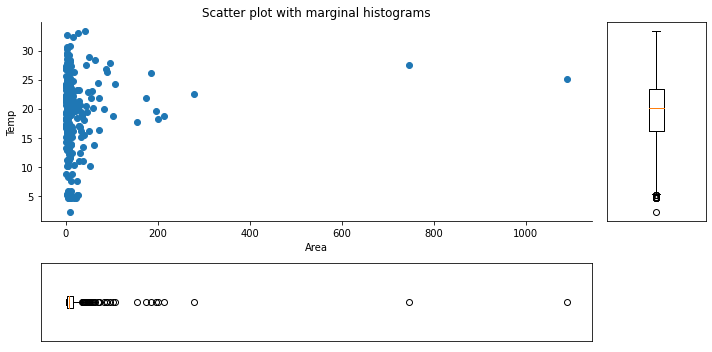

In [11]:
x = df.area
y = df.temp

fig = plt.figure(figsize = (10, 5))

gs = fig.add_gridspec(6, 6)
ax1 = fig.add_subplot(gs[:4, :-1])

ax1.scatter(x, y) 

ax1.set_xlabel("Area")
ax1.set_ylabel("Temp")

ax1.set_title("Scatter plot with marginal histograms")

ax1.spines["right"].set_color("None")
ax1.spines["top"].set_color("None")

ax2 = fig.add_subplot(gs[4:, :-1])
ax2.boxplot(x, vert = False)

ax2.set_xticks([])
ax2.set_yticks([])

ax3 = fig.add_subplot(gs[:4, -1])
ax3.boxplot(y)

ax3.set_xticks([])
ax3.set_yticks([])

fig.tight_layout()

Еще раз видим, как много выбросов в данных по целевой переменной, удалим те, которые не входят в перцентиль (1,99)

In [12]:
df = df[df.area < np.percentile(df.area,(1,99))[1]]
df = df[df.area > np.percentile(df.area,(1,99))[0]]

df.shape

(264, 9)

In [13]:
# Разделим выборку на Х и у

X = df.drop(columns = "area").copy()
y_raw = df.area.copy()

Теперь посмотрим на то, как признаки коррелированы друг с другом

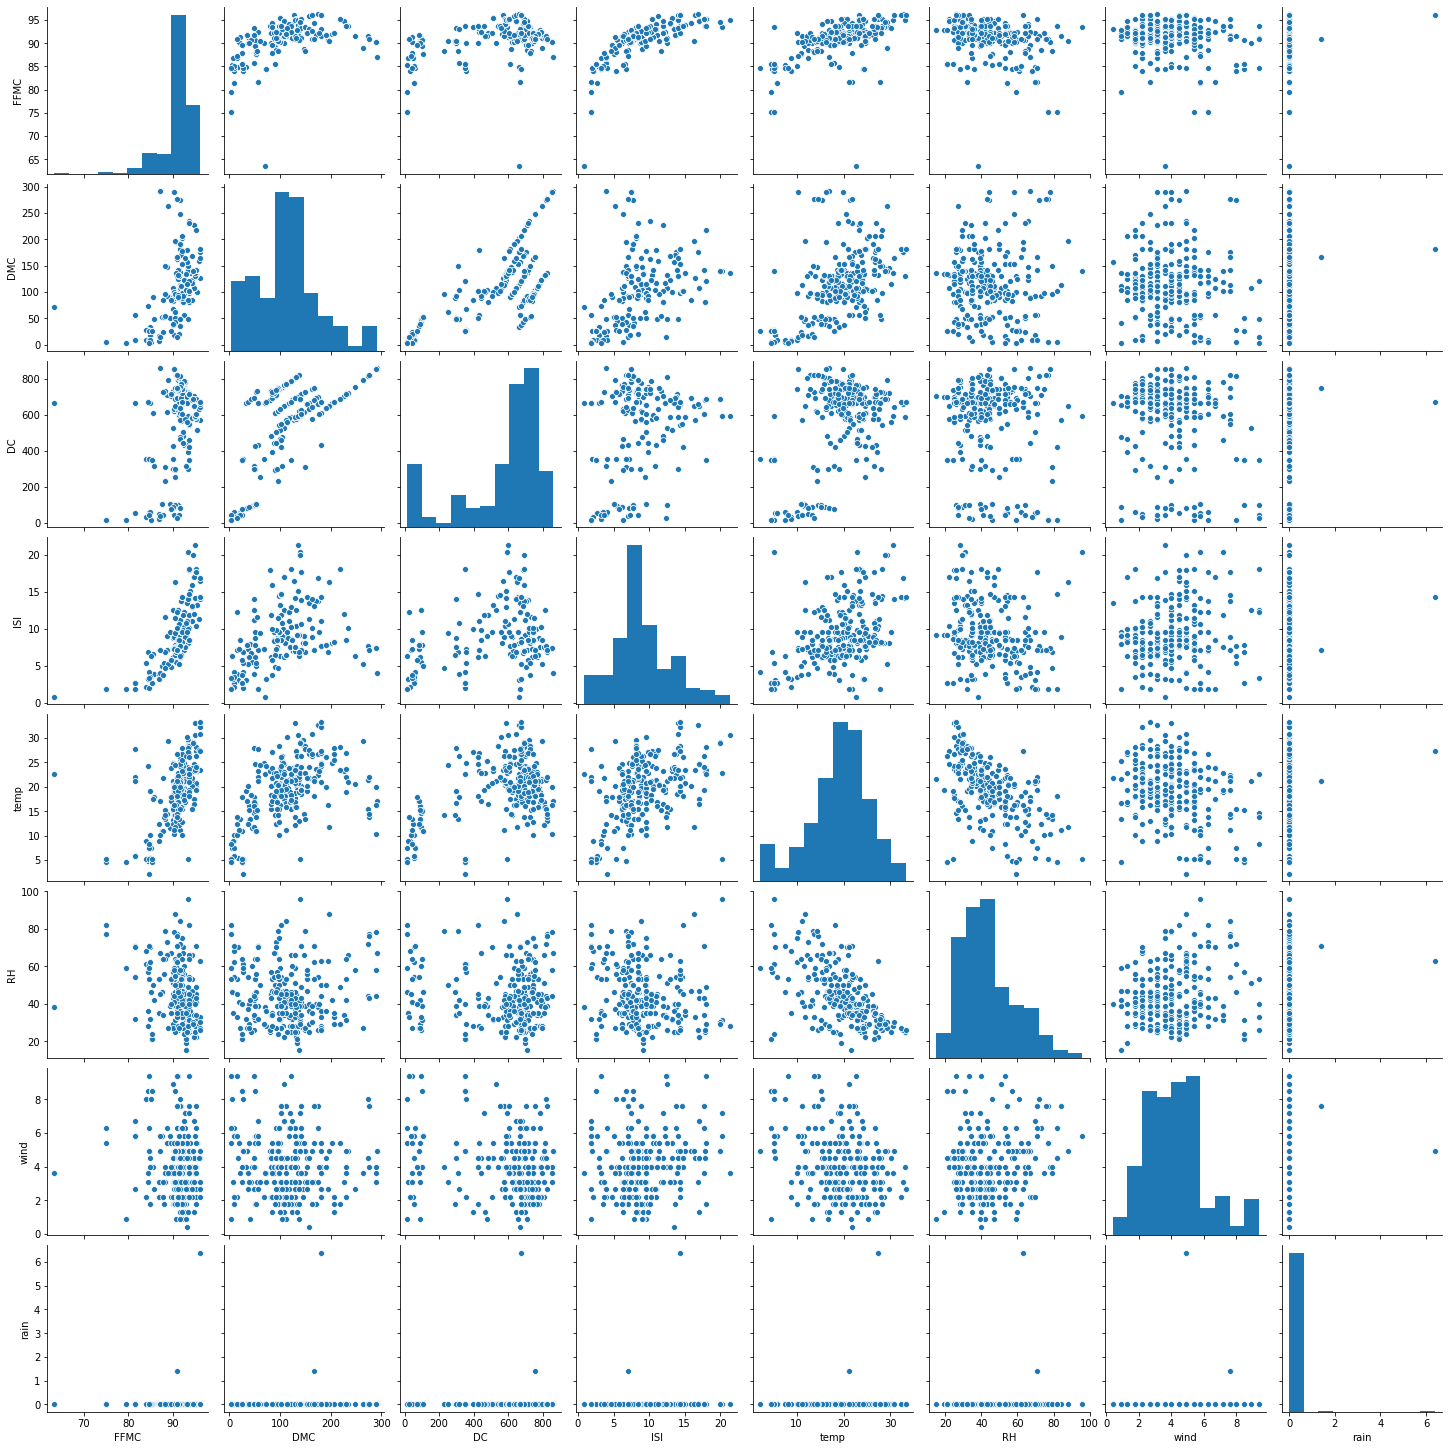

In [14]:
sns.pairplot(X)

На графике видно, что некоторые регрессоры коррелированны (например ICI и FFMC;FFMC и Temp) может возникнуть проблемма мультиколлинеарности

In [15]:
# Скорректируем данные по дождю
df[df.rain != 0]

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
499,96.10,181.10,671.20,14.30,27.30,63,4.90,6.40,10.82
509,91.00,166.90,752.60,7.10,21.10,71,7.60,1.40,2.17


Кажется, регрессор, в котором 2 из 200+ наблюдений ненулевые, не особо релевантен для дальнейшего изучения

In [16]:
X = X.drop(columns = 'rain')
df = df.drop(columns = 'rain')
df.describe()

,FFMC,DMC,DC,ISI,temp,RH,wind,area
count,264.00,264.00,264.00,264.00,264.00,264.00,264.00,264.00
mean,91.00,113.86,569.53,9.09,19.21,43.81,4.10,17.14
std,3.73,61.95,231.98,4.08,6.20,15.13,1.90,32.29
min,63.50,3.20,15.30,0.80,2.20,15.00,0.40,0.24
25%,90.30,81.80,480.80,6.80,16.05,33.00,2.70,2.16
50%,91.60,111.45,665.45,8.40,20.10,41.00,4.00,6.37
75%,92.90,141.22,721.82,11.10,23.33,53.00,4.90,14.84
max,96.20,291.30,860.60,21.30,33.30,96.00,9.40,212.88


In [17]:
#нормируем данные
from sklearn.preprocessing import StandardScaler, MinMaxScaler
normalizer = StandardScaler()
X_real_norm_np = normalizer.fit_transform(X)
X_norm = pd.DataFrame(data=X_real_norm_np, columns=X.columns, index=X.index)
X_norm["Intercept"] = 1
X_norm.describe()

,FFMC,DMC,DC,ISI,temp,RH,wind,Intercept
count,264.00,264.00,264.00,264.00,264.00,264.00,264.00,264.00
mean,-0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,1.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00
min,-7.38,-1.79,-2.39,-2.04,-2.75,-1.91,-1.95,1.00
25%,-0.19,-0.52,-0.38,-0.56,-0.51,-0.72,-0.74,1.00
50%,0.16,-0.04,0.41,-0.17,0.14,-0.19,-0.06,1.00
75%,0.51,0.44,0.66,0.49,0.66,0.61,0.42,1.00
max,1.40,2.87,1.26,3.00,2.28,3.45,2.79,1.00


In [18]:
# также разделим выборку на обучение и тест для потенциального сравнения различных моделей

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_norm, y_raw, test_size=0.2)

print("Размер обучения: ", X_train.shape[0])
print("Размер теста: ", X_test.shape[0])

Размер обучения:  211
Размер теста:  53


# Пункт 3

In [19]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X[['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind']].values, i) for i in range(X.shape[1])]
vif["features"] = ['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind'] 
vif

,VIF Factor,features
0,58.09,FFMC
1,9.26,DMC
2,13.90,DC
3,8.53,ISI
4,28.49,temp
5,13.47,RH
6,6.69,wind


Видим мультиколлинеарность, котороя объясняется, вероятно тем, что индексы хорошо объясняются другими погодными условиями. Есть два разветвления дальнейших событий, бороться с мультиколлинеарностью или нет. В случает "нет" мы также получим несмещенные и эффективные (из несмещенных) оценки, и сможем построить прогноз, но интерпритация будет хромать. Поэтому в будущем можем сделать несколько моделей! Все включенные переменные, с выкинутыми переменными и регуляризованая модель.

#Пункт 4

In [20]:
model_raw = OLS(y_raw,X_norm).fit()
print(model_raw.summary())

                            OLS Regression Results                            
Dep. Variable:                   area   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.9407
Date:                Sat, 20 Jun 2020   Prob (F-statistic):              0.476
Time:                        08:45:44   Log-Likelihood:                -1288.1
No. Observations:                 264   AIC:                             2592.
Df Residuals:                     256   BIC:                             2621.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
FFMC           1.2387      3.273      0.378      0.7

Переменные получились незначимы (кроме константы) поотдельности на уровне большем 90%. При этом в целом F статистика показывает, что есть значимые переменные.

In [21]:
model2 = OLS(y_train,X_train).fit()

y_pred = model2.predict(X_test)

# print out the prediction scores
print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))
print('MAE: {}'.format(mean_absolute_error(y_test, y_pred)))
print('R-squared: {}'.format(r2_score(y_test, y_pred)))

RMSE: 39.020567551240326
MAE: 19.412958934805637
R-squared: 0.02529486353235899


Text(0.5, 1.0, 'Predicted vs True values')

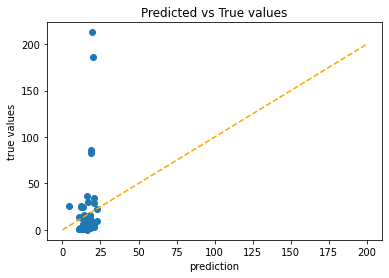

In [22]:
plt.scatter(y_pred, y_test)
plt.plot(np.linspace(0,200,200), np.linspace(0,200,200), c = 'orange', linestyle='--')
plt.xlabel('prediction')
plt.ylabel('true values')
plt.title('Predicted vs True values')

Jarque-Bera test  statistic: 3499.3091, p-value: 0.0
Shapiro-Wilk test  statistic: 0.5737, p-value: 0.0000
Kolmogorov-Smirnov test  statistic: 0.7191, p-value: 0.0000
Anderson-Darling test  statistic: 33.2826, 5% critical value: 0.7760


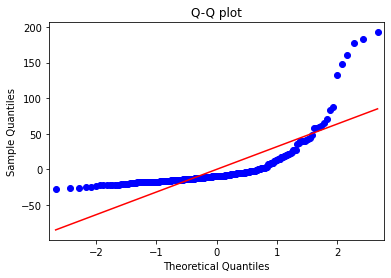

In [23]:
def normality_of_residuals_test(model):
    sm.ProbPlot(model.resid).qqplot(line='s');
    plt.title('Q-Q plot');

    jb = st.jarque_bera(model.resid)
    sw = st.shapiro(model.resid)
    ad = st.anderson(model.resid, dist='norm')
    ks = st.kstest(model.resid, 'norm')
    
    print(f'Jarque-Bera test  statistic: {jb[0]:.4f}, p-value: {jb[1]}')
    print(f'Shapiro-Wilk test  statistic: {sw[0]:.4f}, p-value: {sw[1]:.4f}')
    print(f'Kolmogorov-Smirnov test  statistic: {ks.statistic:.4f}, p-value: {ks.pvalue:.4f}')
    print(f'Anderson-Darling test  statistic: {ad.statistic:.4f}, 5% critical value: {ad.critical_values[2]:.4f}')
    
normality_of_residuals_test(model_raw)

Остатки в целом не нормальны, а что, если протестировать модель с изменением функциональной формы?

In [24]:
y,l_lambda = st.boxcox(y_raw)
y = y_raw**l_lambda
train_data,fitted_lambda = st.boxcox(y_train)

test_data = st.boxcox(y_test, fitted_lambda)

In [25]:
model = OLS(y,X_norm).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   area   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.049
Date:                Sat, 20 Jun 2020   Prob (F-statistic):              0.397
Time:                        08:45:45   Log-Likelihood:                 299.88
No. Observations:                 264   AIC:                            -583.8
Df Residuals:                     256   BIC:                            -555.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
FFMC           0.0017      0.008      0.212      0.8

RMSE: 1.231586253800034
MAE: 1.000716594134517
R-squared: 0.015030879697733979


Text(0.5, 1.0, 'Predicted vs True values')

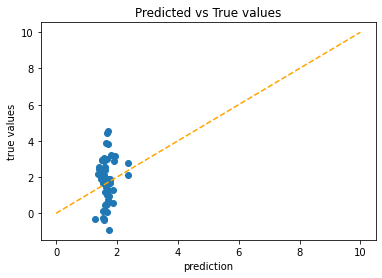

In [26]:
model3 = OLS(train_data,X_train).fit()

y_pred = model3.predict(X_test)

# print out the prediction scores
print('RMSE: {}'.format(np.sqrt(mean_squared_error(test_data, y_pred))))
print('MAE: {}'.format(mean_absolute_error(test_data, y_pred)))
print('R-squared: {}'.format(r2_score(test_data, y_pred)))
plt.scatter(y_pred, test_data)
plt.plot(np.linspace(0,10,10), np.linspace(0,10,10), c = 'orange', linestyle='--')
plt.xlabel('prediction')
plt.ylabel('true values')
plt.title('Predicted vs True values')

Jarque-Bera test  statistic: 2.2699, p-value: 0.3214444349758825
Shapiro-Wilk test  statistic: 0.9932, p-value: 0.2713
Kolmogorov-Smirnov test  statistic: 0.4275, p-value: 0.0000
Anderson-Darling test  statistic: 0.3739, 5% critical value: 0.7760


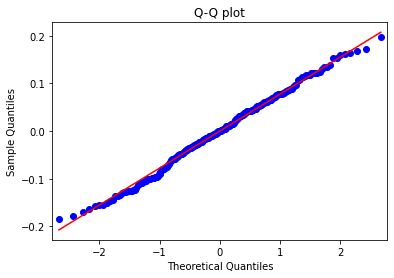

In [27]:
normality_of_residuals_test(model)

С помощью магического преобразования Бокса-Кокса, мы смогли сделать остатки почти нормальным, сократить RMSE в 30 раз и сделать некоторые переменные сильно более значимыми (DMC,RH)! Теперь будем называть нашей моделью - данную модель

In [28]:
print("Степень преобразования Бокса-Кокса: {}".format(round(l_lambda,2)))

Степень преобразования Бокса-Кокса: -0.06


#Пункт 5

In [29]:
median = np.median(X_norm, axis = 0)
median

array([ 0.16154117, -0.03901264,  0.41428066, -0.16876424,  0.14372644,
       -0.18606194, -0.05524811,  1.        ])

In [30]:
T = model.params @ median
V = 1.96 * np.sum(np.square(model.resid)) / (len(X_norm)-X_norm.shape[1])
print("Точечный прогноз площади: ", T**(1/l_lambda))
print("Индивидуальный прогноз площади: [" + str(T**(1/l_lambda) - V), ";",
    str((T**(1/l_lambda) + V)) + "]")

Точечный прогноз площади:  5.735865215788152
Индивидуальный прогноз площади: [5.723661390993784 ; 5.7480690405825206]


Mean:  16.95  Interval: [14.45 ; 20.31]


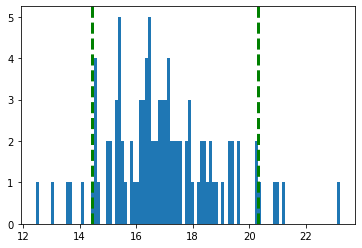

In [31]:
# Для проверки воспользуюсь бутсрэпом для оценки среднего значения целевой переменной
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(df), (n_samples, len(df))) 
    samples = data[indices]
    return samples

n_samples = 100
a_samples = get_bootstrap_samples(np.array(df.area), n_samples)
a_means = np.mean(a_samples, axis = 1)

plt.hist(a_means, bins=100)
b_q5, b_q95 = np.percentile(a_means, [5, 95])
plt.axvline(x=b_q5, linewidth=3, color='g',linestyle='--')
plt.axvline(x=b_q95, linewidth=3, color='g',linestyle='--')
print("Mean: ", round(np.mean(a_means),2)," Interval: ["+str(round(b_q5 ,2)), ";",
    str(round(b_q95 ,2))+ "]")

#Пункт 6

Скорее всего не только площадь сгорания зависит от ветра и/или температуры, но и то, на сколько сильно колеблится эта площадь пропорциональна этим погодным условиям. То есть изначально при высокой температуре, лес больше предрасположен к загоранию, чем при меньшей.

#Пункт 7

In [32]:
X_GK = X_norm.sort_values(by="wind", ascending=False).copy()
y_GK = y[X_GK.index]
X_GK.head()

,FFMC,DMC,DC,ISI,temp,RH,wind,Intercept
168,0.05,-1.06,-2.04,0.84,-0.75,-1.18,2.79,1
475,0.73,0.13,-0.95,2.19,0.56,-0.25,2.79,1
469,0.00,-1.61,-2.35,0.79,-0.89,-0.72,2.79,1
411,-1.72,-1.79,-2.27,-1.42,-1.78,0.61,2.79,1
142,-0.24,-0.09,-0.17,0.84,0.32,0.48,2.52,1


In [33]:
Shape = (X_GK.shape[0] - int(X_GK.shape[0]*0.2)) // 2
Top_X = X_GK.iloc[:Shape]
Top_y = y_GK.iloc[:Shape]
Bot_X = X_GK.iloc[Shape + int(X_GK.shape[0]*0.2):]
Bot_y = y_GK.iloc[Shape + int(X_GK.shape[0]*0.2):]

In [34]:
Top_model = OLS(Top_y,Top_X).fit()
Bot_model = OLS(Bot_y,Bot_X).fit()

In [35]:
rss1 = np.sum(np.square(Top_model.resid))
print("RSS1 = {}".format(rss1))
rss2 = np.sum(np.square(Bot_model.resid))
print("RSS2 = {}".format(rss2))

RSS1 = 0.5845134121372962
RSS2 = 0.7275234699659113


In [36]:
F = rss1 / rss2
print("F-statistic = {}".format(F))
P = st.f(Shape - X_GK.shape[1], Shape - X_GK.shape[1])
if F >= P.cdf(0.05):
  print("Гетероскедостичность имеет место")
else:
  print("Гетероскедостичность не выявлена тестом")

F-statistic = 0.8034289425256399
Гетероскедостичность имеет место


In [37]:
resids = model.resid
gq_test = pd.DataFrame(sms.het_goldfeldquandt(resids, model.model.exog)[:-1],
                           columns=['value'],
                           index=['F statistic', 'p-value'])
gq_test

,value
F statistic,0.74
p-value,0.95


Гетероскедостичность имеет место

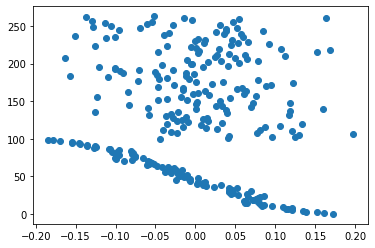

In [38]:
plt.scatter(model.resid, [i for i in range(len(model.resid))])

#Пункт 8

In [39]:
w = np.sum(np.square(model.resid)) / (len(X_norm) - X_norm.shape[1])
mod_wls = sm.WLS(y, X_norm, weights=1./(w ** 2))
res_wls = mod_wls.fit()
print(res_wls.summary())

                            WLS Regression Results                            
Dep. Variable:                   area   R-squared:                       0.028
Model:                            WLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.049
Date:                Sat, 20 Jun 2020   Prob (F-statistic):              0.397
Time:                        08:45:46   Log-Likelihood:                 299.88
No. Observations:                 264   AIC:                            -583.8
Df Residuals:                     256   BIC:                            -555.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
FFMC           0.0017      0.008      0.212      0.8

#Пункт 9

In [40]:
print(OLS(y,X_norm).fit(cov_type='HC0').summary())

                            OLS Regression Results                            
Dep. Variable:                   area   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.693
Date:                Sat, 20 Jun 2020   Prob (F-statistic):              0.111
Time:                        08:45:46   Log-Likelihood:                 299.88
No. Observations:                 264   AIC:                            -583.8
Df Residuals:                     256   BIC:                            -555.2
Df Model:                           7                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
FFMC           0.0017      0.006      0.294      0.7

Метод расчета - 
$V(\hat {b}_{OLS})=(X^TX)^{-1}(X^TVX)(X^TX)^{-1}$, где V - ковариационная матрица случ. ошибок

Результаты расчета изменились, изменилась значимость коэфициентов и оценка стандартных ошибок

In [41]:
print(OLS(y,X_norm).fit(cov_type='HC3').summary())

                            OLS Regression Results                            
Dep. Variable:                   area   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.556
Date:                Sat, 20 Jun 2020   Prob (F-statistic):              0.149
Time:                        08:45:46   Log-Likelihood:                 299.88
No. Observations:                 264   AIC:                            -583.8
Df Residuals:                     256   BIC:                            -555.2
Df Model:                           7                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
FFMC           0.0017      0.006      0.263      0.7

#Пункт 10

In [42]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X_norm)
print(pca.explained_variance_ratio_)

[0.44639073 0.17204188]


In [43]:
X_PCA = pca.fit_transform(X_norm)
print(OLS(y,X_PCA).fit().summary())

                                 OLS Regression Results                                
Dep. Variable:                   area   R-squared (uncentered):                   0.000
Model:                            OLS   Adj. R-squared (uncentered):             -0.008
Method:                 Least Squares   F-statistic:                           0.002805
Date:                Sat, 20 Jun 2020   Prob (F-statistic):                       0.997
Time:                        08:45:46   Log-Likelihood:                         -345.95
No. Observations:                 264   AIC:                                      695.9
Df Residuals:                     262   BIC:                                      703.1
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Кажется, стало сильно хуже. R^2 упал до 0, переменные вовсе не значимы

#Пункт 11

Кажется, реализация задачи минимизации ошибки / максимизации правдоподобия и так реализованы в питоне через гардиентный спуск, поэтому просто переписывать уже написанный код не очень "исследовательски". Вместо этого возникла идея попробовать исследовать данные статистическими методами. Визуально распределение целевой переменной похоже на гамма, с помощью метода моментов попробую подобрать параметры распределения.

In [44]:
M = np.mean(np.array(df.area))
V = np.var(np.array(df.area))
beta = M / V
alpha = M**2/V
print(M, V)

17.143674242424243 1038.4891088484273


Average:  17.749043929270677 ; Variance:  1256.8033767445088
Median:  3.951044780670199
Max:  318.19836165862887
Min:  2.024429464274674e-06
alpha_q5:  0.003420550666139201 alpha_q5:  72.25285626025465


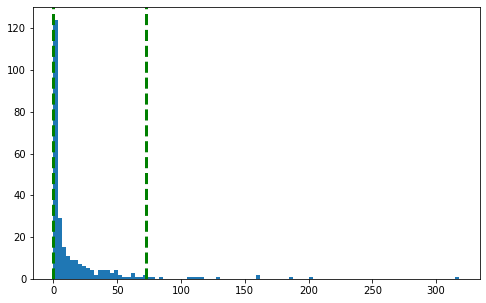

In [45]:
#Вариает посчитанный методом моментов
A = gamma.rvs(scale=1/(beta), a = alpha,  size = len(df.area))
plt.figure(figsize=(8,5))
plt.hist(A, bins = 100)
alpha_q5, alhpa_q95 = np.percentile(A, [5, 95])
plt.axvline(x=alpha_q5, linewidth=3, color='g',linestyle='--')
plt.axvline(x=alhpa_q95, linewidth=3, color='g',linestyle='--')
print("Average: ", np.mean(A), "; Variance: ", np.var(A))
print( "Median: ", np.median(A))
print("Max: ", max(A))
print("Min: ", min(A))
print("alpha_q5: ", alpha_q5, "alpha_q5: ", alhpa_q95)

Теперь стоит сравнить с наблюдаемыми значениями

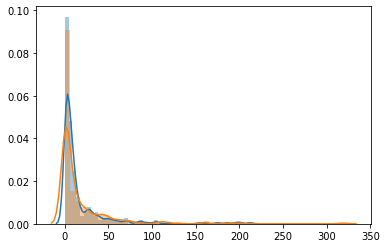

In [46]:
sns.distplot(df.area.values, kde = True, label = "Observed")
sns.distplot(A, kde = True, label = "Theoretical")

Average:  14.62090185191566 ; Variance:  461.5384538136424
Median:  5.793119423735925
Max:  191.46193619142983
Min:  0.2422147440194508
alpha_q5:  0.43800932710335794 alpha_q5:  55.877514392814206


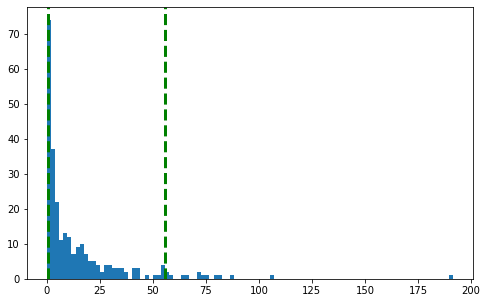

In [47]:
#Вариает посчитанный питоном
loc, a, scale = gamma.fit(df.area)

A = gamma.rvs(loc = a, a = loc, scale = scale, size = len(df.area))
plt.figure(figsize=(8,5))
plt.hist(A, bins = 100)
alpha_q5, alhpa_q95 = np.percentile(A, [5, 95])
plt.axvline(x=alpha_q5, linewidth=3, color='g',linestyle='--')
plt.axvline(x=alhpa_q95, linewidth=3, color='g',linestyle='--')
print("Average: ", np.mean(A), "; Variance: ", np.var(A))
print( "Median: ", np.median(A))
print("Max: ", max(A))
print("Min: ", min(A))
print("alpha_q5: ", alpha_q5, "alpha_q5: ", alhpa_q95)

Теперь стоит сравнить с наблюдаемыми значениями

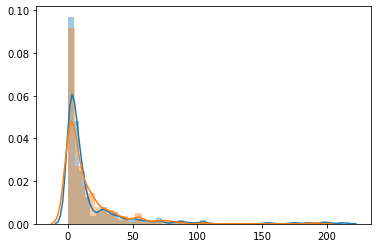

In [48]:
sns.distplot(df.area.values, kde = True, label = "Observed")
sns.distplot(A, kde = True, label = "Theoretical")

Визуально, питон подобрал распределение лучше, чем я методом мементов. Теперь, когда мы знаем приблизительное теоретическое распределение, можем делать статистические тесты, оценивать что-нибудь методом максимального правдоподобия. Это никак не учитывает признаки, но тоже очень полезно для сравнения разных лесов, например.